In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [36]:
root_path = 'gdrive/MyDrive/tailbar-images'

In [37]:
import pathlib
data_dir = pathlib.Path(root_path)

In [38]:
image_count = len(list(data_dir.glob('*/*.PNG')))
print(image_count)

38


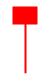

In [39]:
bt = list(data_dir.glob('BT/*'))
PIL.Image.open(str(bt[1]))

In [25]:
batch_size = 4
img_height = 60
img_width = 19

In [40]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 38 files belonging to 2 classes.
Using 31 files for training.


In [41]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 38 files belonging to 2 classes.
Using 7 files for validation.


In [42]:
class_names = train_ds.class_names
print(class_names)

['BT', 'TT']


In [43]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [45]:
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

In [46]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [47]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 60, 19, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 60, 19, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 9, 16)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 9, 32)         4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 4, 32)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 4, 64)         1

In [48]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
8/8 [==============================] - 3s 222ms/step - loss: 0.7085 - accuracy: 0.4839 - val_loss: 0.6160 - val_accuracy: 1.0000
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 0.5714 - accuracy: 0.9032 - val_loss: 0.4781 - val_accuracy: 1.0000
Epoch 3/10
8/8 [==============================] - 0s 14ms/step - loss: 0.3568 - accuracy: 1.0000 - val_loss: 0.2270 - val_accuracy: 1.0000
Epoch 4/10
8/8 [==============================] - 0s 12ms/step - loss: 0.1181 - accuracy: 1.0000 - val_loss: 0.0666 - val_accuracy: 1.0000
Epoch 5/10
8/8 [==============================] - 0s 13ms/step - loss: 0.0370 - accuracy: 1.0000 - val_loss: 0.0173 - val_accuracy: 1.0000
Epoch 6/10
8/8 [==============================] - 0s 16ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 7/10
8/8 [==============================] - 0s 13ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 6.4828e-04 - val_accuracy: 1.0000
Epoch 8/10
8/8 [======

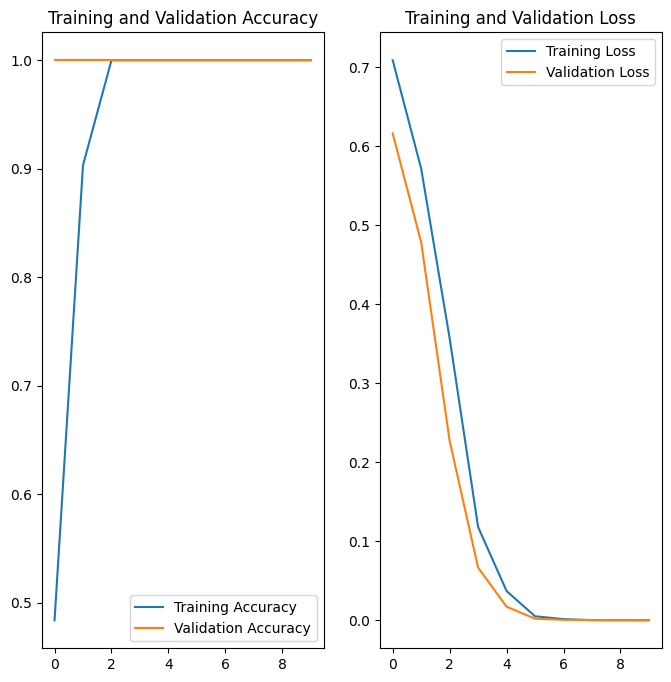

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [51]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

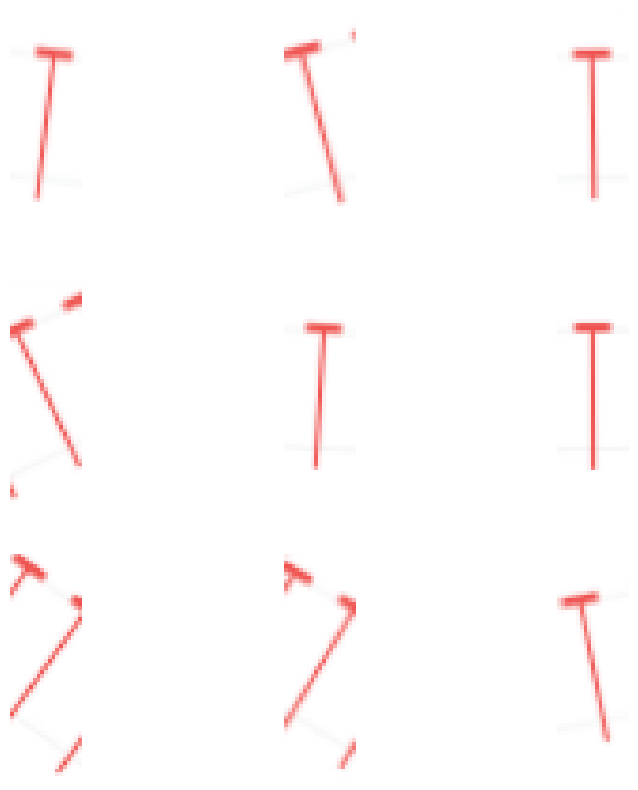

In [52]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [53]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [54]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 60, 19, 3)         0         
                                                                 
 rescaling_3 (Rescaling)     (None, 60, 19, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 60, 19, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 9, 16)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 9, 32)         4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 4, 32)        0         
 2D)                                                  

In [55]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
8/8 [==============================] - 3s 36ms/step - loss: 0.7497 - accuracy: 0.5806 - val_loss: 0.7956 - val_accuracy: 0.5714
Epoch 2/15
8/8 [==============================] - 0s 15ms/step - loss: 0.7265 - accuracy: 0.5484 - val_loss: 0.8119 - val_accuracy: 0.4286
Epoch 3/15
8/8 [==============================] - 0s 16ms/step - loss: 0.7073 - accuracy: 0.5484 - val_loss: 0.6771 - val_accuracy: 0.5714
Epoch 4/15
8/8 [==============================] - 0s 16ms/step - loss: 0.6559 - accuracy: 0.7097 - val_loss: 0.6508 - val_accuracy: 0.5714
Epoch 5/15
8/8 [==============================] - 0s 21ms/step - loss: 0.6350 - accuracy: 0.6774 - val_loss: 0.6127 - val_accuracy: 1.0000
Epoch 6/15
8/8 [==============================] - 0s 16ms/step - loss: 0.5572 - accuracy: 1.0000 - val_loss: 0.5447 - val_accuracy: 0.8571
Epoch 7/15
8/8 [==============================] - 0s 17ms/step - loss: 0.4324 - accuracy: 0.9355 - val_loss: 0.3686 - val_accuracy: 1.0000
Epoch 8/15
8/8 [===========

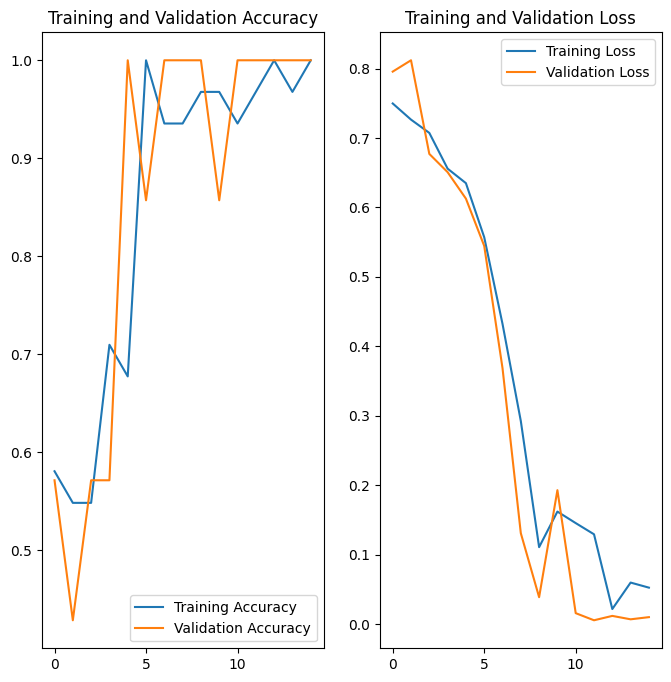

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [57]:
pic_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/c/c1/Long-upper-shadow.svg/100px-Long-upper-shadow.svg.png"
pic_path = tf.keras.utils.get_file('Tailbar', origin=pic_url)

img = tf.keras.utils.load_img(
    pic_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 141ms/step
This image most likely belongs to TT with a 96.79 percent confidence.
